In [ ]:
# %load_ext autoreload
# %autoreload 2
!pip install torchsummary

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
import seaborn as sns

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define data directory based on environment
DATA_DIR_CARIOCA_FREQS_10s = Path("/kaggle/input/carioca-freqs-10s-cnn-bilstm")
DATA_DIR_SYNTH_FREQS_10s = Path("/kaggle/input/synthetic-variety-freqs-10s-cnn-bilstm")
DATA_DIR_WHUREF_FREQS_10s = Path("/kaggle/input/whuref-freqs-10s-cnn-bilstm")

In [ ]:
# Use CUDA if a GPU is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Using device", device)

In [ ]:
# Hyperparameters
NUM_EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
TEST_SIZE = 0.2

In [ ]:
class CNNSpatialExtractor(nn.Module):
    def __init__(self, input_size):
        super(CNNSpatialExtractor, self).__init__()
        # Convolution layers with padding to preserve spatial dimensions
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        final_size = input_size // 8
        
        # Compute the flattened size after convolutions and pooling
        self.fc1 = nn.Linear(64 * final_size * final_size, 1024)  # Flattened size: 64 channels * 5x5
        self.fc2 = nn.Linear(1024, 256)         # Second fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output size: (22x22)
        x = self.pool(F.relu(self.conv2(x)))  # Output size: (11x11)
        x = self.pool(F.relu(self.conv3(x)))  # Output size: (5x5)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))   # First fully connected layer
        x = F.relu(self.fc2(x))   # Second fully connected layer
        return x


# BiLSTM block for temporal feature extraction
class DeepBiLSTMTemporalExtractor(nn.Module):
    def __init__(self, input_size=85, hidden_size=85, num_layers=2):
        super(DeepBiLSTMTemporalExtractor, self).__init__()
        
        # First BiLSTM module
        self.bilstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_size * 2)  # Normalization layer for the first BiLSTM
        
        # Second BiLSTM module
        self.bilstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.norm2 = nn.LayerNorm(hidden_size * 2)  # Normalization layer for the second BiLSTM
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, 512)  # First fully connected layer (input: hidden_size*2, output: 512)
        self.fc2 = nn.Linear(512, 256)  # Second fully connected layer (input: 512, output: 256)

    def forward(self, x):
        # First BiLSTM layer
        lstm_out1, _ = self.bilstm1(x)
        lstm_out1 = self.norm1(lstm_out1)  # Apply normalization
        lstm_out1 = F.relu(lstm_out1)  # Apply ReLU activation
        
        # Second BiLSTM layer
        lstm_out2, _ = self.bilstm2(lstm_out1)
        lstm_out2 = self.norm2(lstm_out2)  # Apply normalization
        lstm_out2 = F.relu(lstm_out2)  # Apply ReLU activation
        
        # Get the last time step output from the sequence
        x = lstm_out2[:, -1, :]  # Shape (batch_size, hidden_size * 2)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # First fully connected layer
        x = F.relu(self.fc2(x))  # Second fully connected layer
        
        return x


class SpatioTemporalAttention(nn.Module):
    def __init__(self, spatial_feature_size, temporal_feature_size):
        super(SpatioTemporalAttention, self).__init__()
        
        self.concat_size = spatial_feature_size + temporal_feature_size   # Size of concatenated features

        # Fully connected layers for feature compression and transformation
        self.fc1 = nn.Linear(self.concat_size, self.concat_size)
        self.fc2 = nn.Linear(self.concat_size, self.concat_size // 8)
        self.fc3 = nn.Linear(self.concat_size // 8, self.concat_size)

        # Fully connected layer for attention weights
        self.fc4 = nn.Linear(self.concat_size, self.concat_size)
    
    def forward(self, spatial_feat, temporal_feat):
        # Concatenate spatial and temporal features
        combined_feat = torch.cat((spatial_feat, temporal_feat), dim=1)  # Shape: (batch_size, concat_size)

        # Apply compression layers with ReLU activation
        x = F.relu(self.fc1(combined_feat))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        # Compute attention weights using sigmoid activation
        attention_weights = torch.sigmoid(self.fc4(x))  # Shape: (batch_size, concat_size)

        # Element-wise multiplication to fuse features with attention weights
        fused_features = combined_feat * attention_weights  # Shape: (batch_size, concat_size)

        return fused_features


class ClassificationNetwork(nn.Module):
    def __init__(self, input_size):
        super(ClassificationNetwork, self).__init__()
        
        # Define fully connected layers
        self.fc1 = nn.Linear(input_size, 400)
        self.fc2 = nn.Linear(400, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        
        # Define dropout layer
        self.dropout = nn.Dropout(0.2)
        
        # Define final fully connected layer for output
        self.fc5 = nn.Linear(32, 1)  # Output is binary classification, so 2 neurons

    def forward(self, x):
        # Pass through the first fully connected layer and apply Leaky ReLU
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        
        # Pass through the second fully connected layer and apply Leaky ReLU
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        
        # Pass through the third fully connected layer and apply Leaky ReLU
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        
        # Pass through the fourth fully connected layer and apply Leaky ReLU
        x = F.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        
        # Output layer with softmax activation
        x = self.fc5(x)
        #x = F.softmax(x, dim=1)  # Use log_softmax for numerical stability
        
        return x

# Complete Network
class ParallelCNNBiLSTM(nn.Module):
    def __init__(self, temporal_input_size, spatial_input_size):
        super(ParallelCNNBiLSTM, self).__init__()
        self.spatial_extractor = CNNSpatialExtractor(input_size = spatial_input_size)
        self.temporal_extractor = DeepBiLSTMTemporalExtractor(input_size=temporal_input_size, hidden_size=temporal_input_size)
        self.attention = SpatioTemporalAttention(256, 256)
        self.classifier = ClassificationNetwork(input_size=2 * 256)

    def forward(self, spatial_input, temporal_input):
        spatial_features = self.spatial_extractor(spatial_input)
        temporal_features = self.temporal_extractor(temporal_input)
        fused_features = self.attention(spatial_features, temporal_features)
        output = self.classifier(fused_features)
        return output

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
spatial_input_size = 46  # Height and width for CNN input
temporal_input_size = 25  # Input size for LSTM
sequence_length = 85  # Temporal sequence length

# Create model
model = ParallelCNNBiLSTM(temporal_input_size=temporal_input_size, spatial_input_size=spatial_input_size).to(device)

# Print summary using torchinfo
from torchinfo import summary
summary(model, input_size=[(BATCH_SIZE, 1, spatial_input_size, spatial_input_size), (BATCH_SIZE, sequence_length, temporal_input_size)])

In [ ]:
###...............................Load the data...............................###
data_spatial_synth = np.load(DATA_DIR_SYNTH_FREQS_10s / "synthetic_spatial_freqs.npy", allow_pickle=True)
data_temporal_synth = np.load(DATA_DIR_SYNTH_FREQS_10s / "synthetic_temporal_freqs.npy", allow_pickle=True)
labels_synth = np.load(DATA_DIR_SYNTH_FREQS_10s / "synthetic_labels_freqs.npy", allow_pickle=True)

data_spatial_whuref = np.load(DATA_DIR_WHUREF_FREQS_10s / "whu_ref_spatial_freqs.npy", allow_pickle=True)
data_temporal_whuref = np.load(DATA_DIR_WHUREF_FREQS_10s / "whu_ref_temporal_freqs.npy", allow_pickle=True)
labels_whuref = np.load(DATA_DIR_WHUREF_FREQS_10s / "whu_ref_labels_freqs.npy", allow_pickle=True)

data_spatial_carioca = np.load(DATA_DIR_CARIOCA_FREQS_10s / "carioca_spatial_freqs.npy", allow_pickle=True)
data_temporal_carioca = np.load(DATA_DIR_CARIOCA_FREQS_10s / "carioca_temporal_freqs.npy", allow_pickle=True)
labels_carioca = np.load(DATA_DIR_CARIOCA_FREQS_10s / "carioca_labels_freqs.npy", allow_pickle=True)



###...............................Normalize...............................###

## Spatial Data Synthetic
data_spatial_reshaped_synth = data_spatial_synth.reshape(data_spatial_synth.shape[0], -1) # Reshape data for RobustScaler (n_samples, n_features) format
scaler_spatial = RobustScaler() # Apply RobustScaler
data_spatial_normalized_synth = scaler_spatial.fit_transform(data_spatial_reshaped_synth)
data_spatial_normalized_synth = data_spatial_normalized_synth.reshape(data_spatial_synth.shape) # Reshape back to original shape
data_spatial_tensor_synth = torch.tensor(data_spatial_normalized_synth, dtype=torch.float32) # Convert to tensors

## Temporal Data Synthetic
data_temporal_reshaped_synth = data_temporal_synth.reshape(data_temporal_synth.shape[0], -1) # Reshape data for RobustScaler (n_samples, n_features) format
scaler_temporal = RobustScaler() # Apply RobustScaler
data_temporal_normalized_synth = scaler_temporal.fit_transform(data_temporal_reshaped_synth)
data_temporal_normalized_synth = data_temporal_normalized_synth.reshape(data_temporal_synth.shape) # Reshape back to original shape
data_temporal_tensor_synth = torch.tensor(data_temporal_normalized_synth, dtype=torch.float32) # Convert to tensors


## Spatial Data Whuref
data_spatial_reshaped_whuref = data_spatial_whuref.reshape(data_spatial_whuref.shape[0], -1) # Reshape data for RobustScaler (n_samples, n_features) format
scaler_spatial = RobustScaler() # Apply RobustScaler
data_spatial_normalized_whuref = scaler_spatial.fit_transform(data_spatial_reshaped_whuref)
data_spatial_normalized_whuref = data_spatial_normalized_whuref.reshape(data_spatial_whuref.shape) # Reshape back to original shape
data_spatial_tensor_whuref = torch.tensor(data_spatial_normalized_whuref, dtype=torch.float32) # Convert to tensors

## Temporal Data Whuref
data_temporal_reshaped_whuref = data_temporal_whuref.reshape(data_temporal_whuref.shape[0], -1) # Reshape data for RobustScaler (n_samples, n_features) format
scaler_temporal = RobustScaler() # Apply RobustScaler
data_temporal_normalized_whuref = scaler_temporal.fit_transform(data_temporal_reshaped_whuref)
data_temporal_normalized_whuref = data_temporal_normalized_whuref.reshape(data_temporal_whuref.shape) # Reshape back to original shape
data_temporal_tensor_whuref = torch.tensor(data_temporal_normalized_whuref, dtype=torch.float32) # Convert to tensors


## Spatial Data Carioca
data_spatial_reshaped_carioca = data_spatial_carioca.reshape(data_spatial_carioca.shape[0], -1) # Reshape data for RobustScaler (n_samples, n_features) format
scaler_spatial = RobustScaler() # Apply RobustScaler
data_spatial_normalized_carioca = scaler_spatial.fit_transform(data_spatial_reshaped_carioca)
data_spatial_normalized_carioca = data_spatial_normalized_carioca.reshape(data_spatial_carioca.shape) # Reshape back to original shape
data_spatial_tensor_carioca = torch.tensor(data_spatial_normalized_carioca, dtype=torch.float32) # Convert to tensors

## Temporal Data Carioca
data_temporal_reshaped_carioca = data_temporal_carioca.reshape(data_temporal_carioca.shape[0], -1) # Reshape data for RobustScaler (n_samples, n_features) format
scaler_temporal = RobustScaler() # Apply RobustScaler
data_temporal_normalized_carioca = scaler_temporal.fit_transform(data_temporal_reshaped_carioca)
data_temporal_normalized_carioca = data_temporal_normalized_carioca.reshape(data_temporal_carioca.shape) # Reshape back to original shape
data_temporal_tensor_carioca = torch.tensor(data_temporal_normalized_carioca, dtype=torch.float32) # Convert to tensors




###...............................Split into Training Validation and Test data...............................###

## Synthetic
X_spatial_train_synth, X_spatial_test_synth, X_temporal_train_synth, X_temporal_test_synth, y_train_synth, y_test_synth = (
    train_test_split(
        data_spatial_tensor_synth,
        data_temporal_tensor_synth,
        labels_synth,
        test_size=TEST_SIZE,
        random_state=0,
        stratify=labels_synth,
    )
)

X_spatial_train_synth, X_spatial_val_synth, X_temporal_train_synth, X_temporal_val_synth, y_train_synth, y_val_synth = (
    train_test_split(
        X_spatial_train_synth,
        X_temporal_train_synth,
        y_train_synth,
        test_size=TEST_SIZE,
        random_state=0,
        stratify=y_train_synth,
    )
)

## Whuref
X_spatial_train_whuref, X_spatial_test_whuref, X_temporal_train_whuref, X_temporal_test_whuref, y_train_whuref, y_test_whuref = (
    train_test_split(
        data_spatial_tensor_whuref,
        data_temporal_tensor_whuref,
        labels_whuref,
        test_size=TEST_SIZE,
        random_state=0,
        stratify=labels_whuref,
    )
)

X_spatial_train_whuref, X_spatial_val_whuref, X_temporal_train_whuref, X_temporal_val_whuref, y_train_whuref, y_val_whuref = (
    train_test_split(
        X_spatial_train_whuref,
        X_temporal_train_whuref,
        y_train_whuref,
        test_size=TEST_SIZE,
        random_state=0,
        stratify=y_train_whuref,
    )
)


## Carioca
X_spatial_train_carioca, X_spatial_test_carioca, X_temporal_train_carioca, X_temporal_test_carioca, y_train_carioca, y_test_carioca = (
    train_test_split(
        data_spatial_tensor_carioca,
        data_temporal_tensor_carioca,
        labels_carioca,
        test_size=TEST_SIZE,
        random_state=0,
        stratify=labels_carioca,
    )
)

X_spatial_train_carioca, X_spatial_val_carioca, X_temporal_train_carioca, X_temporal_val_carioca, y_train_carioca, y_val_carioca = (
    train_test_split(
        X_spatial_train_carioca,
        X_temporal_train_carioca,
        y_train_carioca,
        test_size=TEST_SIZE,
        random_state=0,
        stratify=y_train_carioca,
    )
)

## Combine Training Data
X_spatial_train = torch.cat((X_spatial_train_synth, X_spatial_train_whuref, X_spatial_train_carioca), dim=0)
X_temporal_train = torch.cat((X_temporal_train_synth, X_temporal_train_whuref,X_temporal_train_carioca), dim=0)
y_train = np.concatenate((y_train_synth, y_train_whuref, y_train_carioca), axis=0)

## Combine Validation Data
X_spatial_val = torch.cat((X_spatial_val_synth, X_spatial_val_whuref, X_spatial_val_carioca), dim=0)
X_temporal_val = torch.cat((X_temporal_val_synth, X_temporal_val_whuref, X_temporal_val_carioca), dim=0)
y_val = np.concatenate((y_val_synth, y_val_whuref, y_val_carioca), axis=0)

## Combine Validation Data
X_spatial_test = torch.cat((X_spatial_test_synth, X_spatial_test_whuref, X_spatial_test_carioca), dim=0)
X_temporal_test = torch.cat((X_temporal_test_synth, X_temporal_test_whuref, X_temporal_test_carioca), dim=0)
y_test = np.concatenate((y_test_synth, y_test_whuref, y_test_carioca), axis=0)



###..................................Convert Data Tensors and move to the GPU..................................###
# Convert spatial data tensors and move to device
X_spatial_train = X_spatial_train.unsqueeze(1).to(device)
X_spatial_val = X_spatial_val.unsqueeze(1).to(device)
X_spatial_test = X_spatial_test.unsqueeze(1).to(device)
X_spatial_test_synth = X_spatial_test_synth.unsqueeze(1).to(device)
X_spatial_test_whuref = X_spatial_test_whuref.unsqueeze(1).to(device)
X_spatial_test_carioca = X_spatial_test_carioca.unsqueeze(1).to(device)

# Convert temporal data tensors and move to device
X_temporal_train = X_temporal_train.to(device)
X_temporal_val = X_temporal_val.to(device)
X_temporal_test = X_temporal_test.to(device)
X_temporal_test_synth = X_temporal_test_synth.to(device)
X_temporal_test_whuref = X_temporal_test_whuref.to(device)
X_temporal_test_carioca = X_temporal_test_carioca.to(device)

# Convert labels to tensors and move to device
y_train = torch.LongTensor(y_train).to(device)
y_val = torch.LongTensor(y_val).to(device)
y_test = torch.LongTensor(y_test).to(device)
y_test_synth = torch.LongTensor(y_test_synth).to(device)
y_test_whuref = torch.LongTensor(y_test_whuref).to(device)
y_test_carioca = torch.LongTensor(y_test_carioca).to(device)



###.....................Create TensorDatasets for spatial and temporal inputs.....................###
train_dataset = TensorDataset(X_spatial_train, X_temporal_train, y_train)
val_dataset = TensorDataset(X_spatial_val, X_temporal_val, y_val)
test_dataset = TensorDataset(X_spatial_test, X_temporal_test, y_test)
test_dataset_synth = TensorDataset(X_spatial_test_synth, X_temporal_test_synth, y_test_synth)
test_dataset_whuref = TensorDataset(X_spatial_test_whuref, X_temporal_test_whuref, y_test_whuref)
test_dataset_carioca = TensorDataset(X_spatial_test_carioca, X_temporal_test_carioca, y_test_carioca)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader_synth = DataLoader(test_dataset_synth, batch_size=BATCH_SIZE, shuffle=False)
test_loader_whuref = DataLoader(test_dataset_whuref, batch_size=BATCH_SIZE, shuffle=False)
test_loader_carioca = DataLoader(test_dataset_carioca, batch_size=BATCH_SIZE, shuffle=False)



###.........................Check label distribution for training.........................###
unique, counts = np.unique(y_train.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_train distribution: {class_distribution}")

unique, counts = np.unique(y_val.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_val distribution: {class_distribution}")

unique, counts = np.unique(y_test.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_test distribution: {class_distribution}")

unique, counts = np.unique(y_test_synth.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_test_synth distribution: {class_distribution}")

unique, counts = np.unique(y_test_whuref.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_test_whuref distribution: {class_distribution}")

unique, counts = np.unique(y_test_carioca.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_test_ distribution: {class_distribution}")

In [ ]:
# Initialize loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Adam optimizer

In [ ]:
# Initialize EarlyStopping object
#early_stopping = EarlyStopping(patience=100, min_delta=0.01)

# Training and validation loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for spatial_inputs, temporal_inputs, labels in train_loader:  # Assuming data loader returns spatial and temporal inputs
        optimizer.zero_grad()
        outputs = model(spatial_inputs, temporal_inputs)
        
        # Ensure labels have the same shape as outputs
        labels = labels.unsqueeze(1).float()  # Convert [64] to [64, 1]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Use sigmoid to get predictions for binary classification
        predictions = torch.sigmoid(outputs)
        predicted_labels = (predictions > 0.5).float()  # Convert to binary predictions
        
        total_train += labels.size(0)
        correct_train += (predicted_labels == labels).sum().item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for spatial_inputs, temporal_inputs, labels in val_loader:  # Assuming data loader returns spatial and temporal inputs
            outputs = model(spatial_inputs, temporal_inputs)
            
            # Ensure labels have the same shape as outputs
            labels = labels.unsqueeze(1).float()  # Convert [64] to [64, 1]

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Use sigmoid to get predictions for binary classification
            predictions = torch.sigmoid(outputs)
            predicted_labels = (predictions > 0.5).float()  # Convert to binary predictions

            total_val += labels.size(0)
            correct_val += (predicted_labels == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    tqdm.write(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    '''
    # Check early stopping condition
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break'''

In [15]:
spatial_input_size = 46  # Height and width for CNN input
temporal_input_size = 25  # Input size for LSTM
sequence_length = 85  # Temporal sequence length

# Define the Model
model = ParallelCNNBiLSTM(temporal_input_size=temporal_input_size, spatial_input_size=spatial_input_size).to(device)

# Load the saved model weights
model.load_state_dict(torch.load('//kaggle/input/all-freqs-10s-cnn-bilstm/pytorch/default/1/All_freqs_10s_cnn-bilstm.pth', weights_only=True))



<All keys matched successfully>

Test Loss: 0.2361, Test Accuracy: 0.9441, Test Precision: 0.9133, Test Recall (tampered): 0.9814, Test Recall (untampered): 0.9068


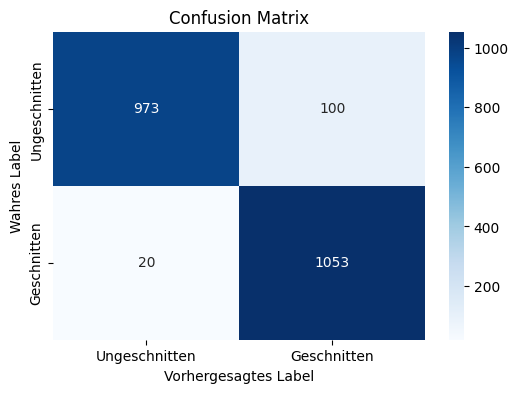

In [16]:
## Alle Daten

# Testing phase
model.eval()
test_loss = 0.0
correct = 0
total = 0
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0  # For untampered sample recall

# Confusion matrix elements
confusion_matrix = torch.zeros(2, 2)  # 2x2 for binary classification

with torch.no_grad():
    for spatial_inputs, temporal_inputs, labels in test_loader:  # Assuming data loader returns spatial and temporal inputs
        outputs = model(spatial_inputs, temporal_inputs)
        
        labels = labels.unsqueeze(1).float()  # Adjust labels to match the output dimension
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        predictions = torch.sigmoid(outputs)
        predicted_labels = (predictions > 0.5).float()  # Convert to binary labels
        
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
        
        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted_labels.view(-1)):  # Iterate over true and predicted labels
            confusion_matrix[int(t.long()), int(p.long())] += 1  # Fill confusion matrix
        
        # Calculate True Positives, False Positives, False Negatives, and True Negatives
        true_positive += ((predicted_labels == 1) & (labels == 1)).sum().item()
        false_positive += ((predicted_labels == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted_labels == 0) & (labels == 1)).sum().item()
        true_negative += ((predicted_labels == 0) & (labels == 0)).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

# Calculate Precision
if true_positive + false_positive > 0:
    precision = true_positive / (true_positive + false_positive)
else:
    precision = 0.0  # Avoid division by zero

# Calculate Recall for tampered samples (positive class)
if true_positive + false_negative > 0:
    recall_tampered = true_positive / (true_positive + false_negative)
else:
    recall_tampered = 0.0  # Avoid division by zero

# Calculate Recall for untampered samples (negative class)
if true_negative + false_positive > 0:
    recall_untampered = true_negative / (true_negative + false_positive)
else:
    recall_untampered = 0.0  # Avoid division by zero

# Print results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall (tampered): {recall_tampered:.4f}, Test Recall (untampered): {recall_untampered:.4f}")


# Convert confusion matrix to numpy for plotting
cm = confusion_matrix.numpy()

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Ungeschnitten', 'Geschnitten'], yticklabels=['Ungeschnitten', 'Geschnitten'])
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Confusion Matrix')
plt.savefig('all_confusion_matrix_cnn-bilstm_all_freqs.pdf', dpi=300)
plt.show()

In [ ]:
## Synthetische Daten

# Testing phase
model.eval()
test_loss = 0.0
correct = 0
total = 0
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0  # For untampered sample recall

# Confusion matrix elements
confusion_matrix = torch.zeros(2, 2)  # 2x2 for binary classification

with torch.no_grad():
    for spatial_inputs, temporal_inputs, labels in test_loader_synth:  # Assuming data loader returns spatial and temporal inputs
        outputs = model(spatial_inputs, temporal_inputs)
        
        labels = labels.unsqueeze(1).float()  # Adjust labels to match the output dimension
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        predictions = torch.sigmoid(outputs)
        predicted_labels = (predictions > 0.5).float()  # Convert to binary labels
        
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
        
        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted_labels.view(-1)):  # Iterate over true and predicted labels
            confusion_matrix[int(t.long()), int(p.long())] += 1  # Fill confusion matrix
        
        # Calculate True Positives, False Positives, False Negatives, and True Negatives
        true_positive += ((predicted_labels == 1) & (labels == 1)).sum().item()
        false_positive += ((predicted_labels == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted_labels == 0) & (labels == 1)).sum().item()
        true_negative += ((predicted_labels == 0) & (labels == 0)).sum().item()

test_loss /= len(test_loader_synth)
test_accuracy = correct / total

# Calculate Precision
if true_positive + false_positive > 0:
    precision = true_positive / (true_positive + false_positive)
else:
    precision = 0.0  # Avoid division by zero

# Calculate Recall for tampered samples (positive class)
if true_positive + false_negative > 0:
    recall_tampered = true_positive / (true_positive + false_negative)
else:
    recall_tampered = 0.0  # Avoid division by zero

# Calculate Recall for untampered samples (negative class)
if true_negative + false_positive > 0:
    recall_untampered = true_negative / (true_negative + false_positive)
else:
    recall_untampered = 0.0  # Avoid division by zero

# Print results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall (tampered): {recall_tampered:.4f}, Test Recall (untampered): {recall_untampered:.4f}")

In [ ]:
# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", alpha=0.7)
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", alpha=0.7)
plt.plot(val_accuracies, label="Validation Accuracy", alpha=0.7)
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training und Validation Accuracy")
plt.savefig('Valdidation_accuracy_and_loss_cnn-bilstm_all_freqs.pdf', dpi=300)
plt.tight_layout()
plt.show()


# Convert confusion matrix to numpy for plotting
cm = confusion_matrix.numpy()

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Ungeschnitten', 'Geschnitten'], yticklabels=['Ungeschnitten', 'Geschnitten'])
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Confusion Matrix')
plt.savefig('synth_confusion_matrix_cnn-bilstm_all_freqs.pdf', dpi=300)
plt.show()

In [ ]:
## WHU Ref Data

# Testing phase
model.eval()
test_loss = 0.0
correct = 0
total = 0
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0  # For untampered sample recall

# Confusion matrix elements
confusion_matrix = torch.zeros(2, 2)  # 2x2 for binary classification

with torch.no_grad():
    for spatial_inputs, temporal_inputs, labels in test_loader_whuref:  # Assuming data loader returns spatial and temporal inputs
        outputs = model(spatial_inputs, temporal_inputs)
        
        labels = labels.unsqueeze(1).float()  # Adjust labels to match the output dimension
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        predictions = torch.sigmoid(outputs)
        predicted_labels = (predictions > 0.5).float()  # Convert to binary labels
        
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
        
        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted_labels.view(-1)):  # Iterate over true and predicted labels
            confusion_matrix[int(t.long()), int(p.long())] += 1  # Fill confusion matrix
        
        # Calculate True Positives, False Positives, False Negatives, and True Negatives
        true_positive += ((predicted_labels == 1) & (labels == 1)).sum().item()
        false_positive += ((predicted_labels == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted_labels == 0) & (labels == 1)).sum().item()
        true_negative += ((predicted_labels == 0) & (labels == 0)).sum().item()

test_loss /= len(test_loader_whuref)
test_accuracy = correct / total

# Calculate Precision
if true_positive + false_positive > 0:
    precision = true_positive / (true_positive + false_positive)
else:
    precision = 0.0  # Avoid division by zero

# Calculate Recall for tampered samples (positive class)
if true_positive + false_negative > 0:
    recall_tampered = true_positive / (true_positive + false_negative)
else:
    recall_tampered = 0.0  # Avoid division by zero

# Calculate Recall for untampered samples (negative class)
if true_negative + false_positive > 0:
    recall_untampered = true_negative / (true_negative + false_positive)
else:
    recall_untampered = 0.0  # Avoid division by zero

# Print results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall (tampered): {recall_tampered:.4f}, Test Recall (untampered): {recall_untampered:.4f}")

In [ ]:
# Convert confusion matrix to numpy for plotting
cm = confusion_matrix.numpy()

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Ungeschnitten', 'Geschnitten'], yticklabels=['Ungeschnitten', 'Geschnitten'])
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Confusion Matrix')
plt.savefig('whuref_confusion_matrix_cnn-bilstm_all_freqs.pdf', dpi=300)
plt.show()

In [ ]:
## Carioca Data

# Testing phase
model.eval()
test_loss = 0.0
correct = 0
total = 0
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0  # For untampered sample recall

# Confusion matrix elements
confusion_matrix = torch.zeros(2, 2)  # 2x2 for binary classification

with torch.no_grad():
    for spatial_inputs, temporal_inputs, labels in test_loader_carioca:  # Assuming data loader returns spatial and temporal inputs
        outputs = model(spatial_inputs, temporal_inputs)
        
        labels = labels.unsqueeze(1).float()  # Adjust labels to match the output dimension
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        predictions = torch.sigmoid(outputs)
        predicted_labels = (predictions > 0.5).float()  # Convert to binary labels
        
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
        
        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted_labels.view(-1)):  # Iterate over true and predicted labels
            confusion_matrix[int(t.long()), int(p.long())] += 1  # Fill confusion matrix
        
        # Calculate True Positives, False Positives, False Negatives, and True Negatives
        true_positive += ((predicted_labels == 1) & (labels == 1)).sum().item()
        false_positive += ((predicted_labels == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted_labels == 0) & (labels == 1)).sum().item()
        true_negative += ((predicted_labels == 0) & (labels == 0)).sum().item()

test_loss /= len(test_loader_carioca)
test_accuracy = correct / total

# Calculate Precision
if true_positive + false_positive > 0:
    precision = true_positive / (true_positive + false_positive)
else:
    precision = 0.0  # Avoid division by zero

# Calculate Recall for tampered samples (positive class)
if true_positive + false_negative > 0:
    recall_tampered = true_positive / (true_positive + false_negative)
else:
    recall_tampered = 0.0  # Avoid division by zero

# Calculate Recall for untampered samples (negative class)
if true_negative + false_positive > 0:
    recall_untampered = true_negative / (true_negative + false_positive)
else:
    recall_untampered = 0.0  # Avoid division by zero

# Print results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall (tampered): {recall_tampered:.4f}, Test Recall (untampered): {recall_untampered:.4f}")

In [ ]:
## Plot Carioca confusion matrix
# Convert confusion matrix to numpy for plotting
cm = confusion_matrix.numpy()

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Ungeschnitten', 'Geschnitten'], yticklabels=['Ungeschnitten', 'Geschnitten'])
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Confusion Matrix')
plt.savefig('carioca_confusion_matrix_cnn-bilstm_all_freqs.pdf', dpi=300)
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), "All_freqs_10s_cnn-bilstm.pth")
print("Model saved successfully!")